In [1]:
import os
import sys
import pickle
import numpy as np
from math import exp
from scipy import stats
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from vizsequence.viz_sequence import plot_weights_given_ax
from scipy.special import softmax
import keras
import keras.losses
from keras.models import Model, Sequential, load_model
from keras import backend as K
import numpy.random as rng
import seaborn as sns
from collections import OrderedDict
from basepair.losses import twochannel_multinomial_nll
import modisco
import modisco.tfmodisco_workflow.workflow
import h5py
import modisco.util
from collections import Counter
from modisco.visualization import viz_sequence
import modisco.affinitymat.core
import modisco.cluster.phenograph.core
import modisco.cluster.phenograph.cluster
import modisco.cluster.core
import modisco.aggregator
%matplotlib inline

Using TensorFlow backend.
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/amr1/mi

2020-12-09 00:25:53,559 [WARNING] From /users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

TF-MoDISco is using the TensorFlow backend.


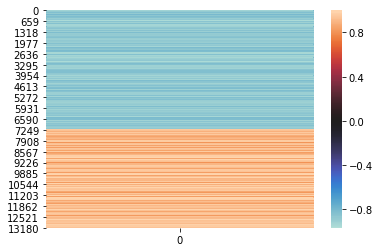


metacluster_0


pattern_0: 465 seqlets



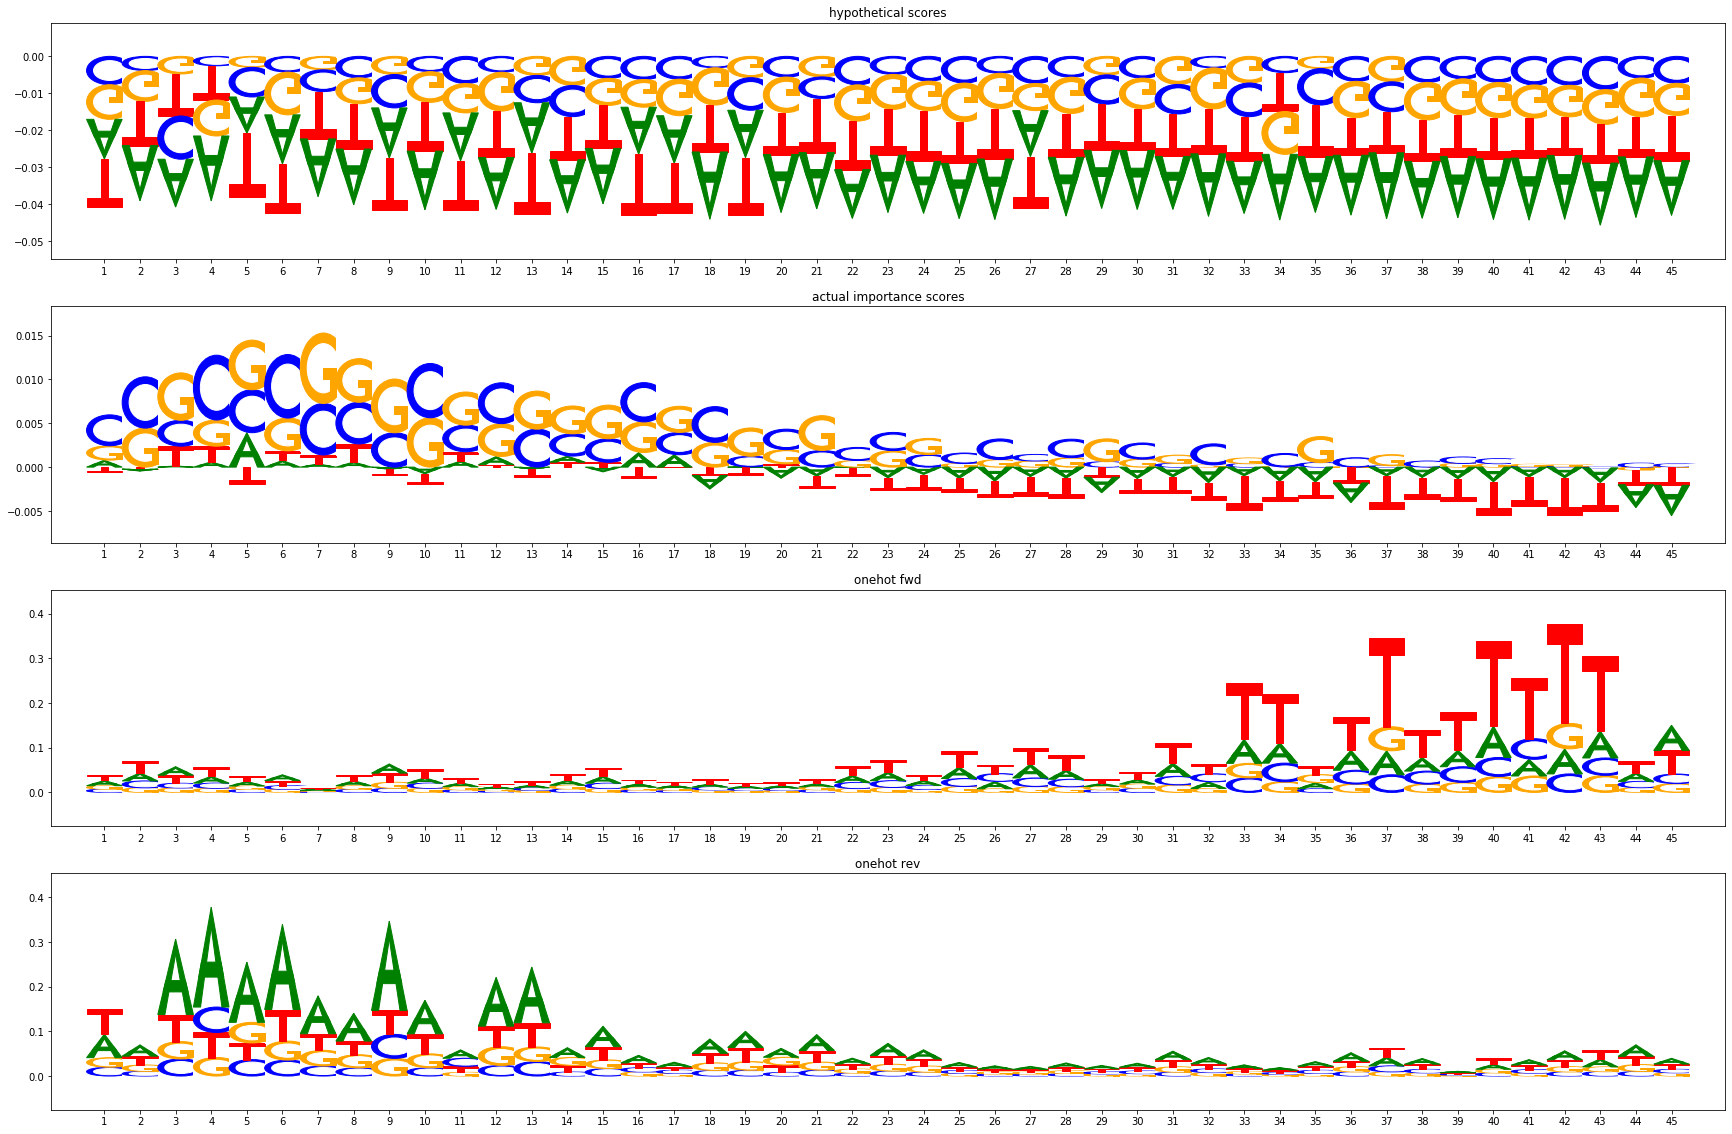


metacluster_1


pattern_0: 1101 seqlets



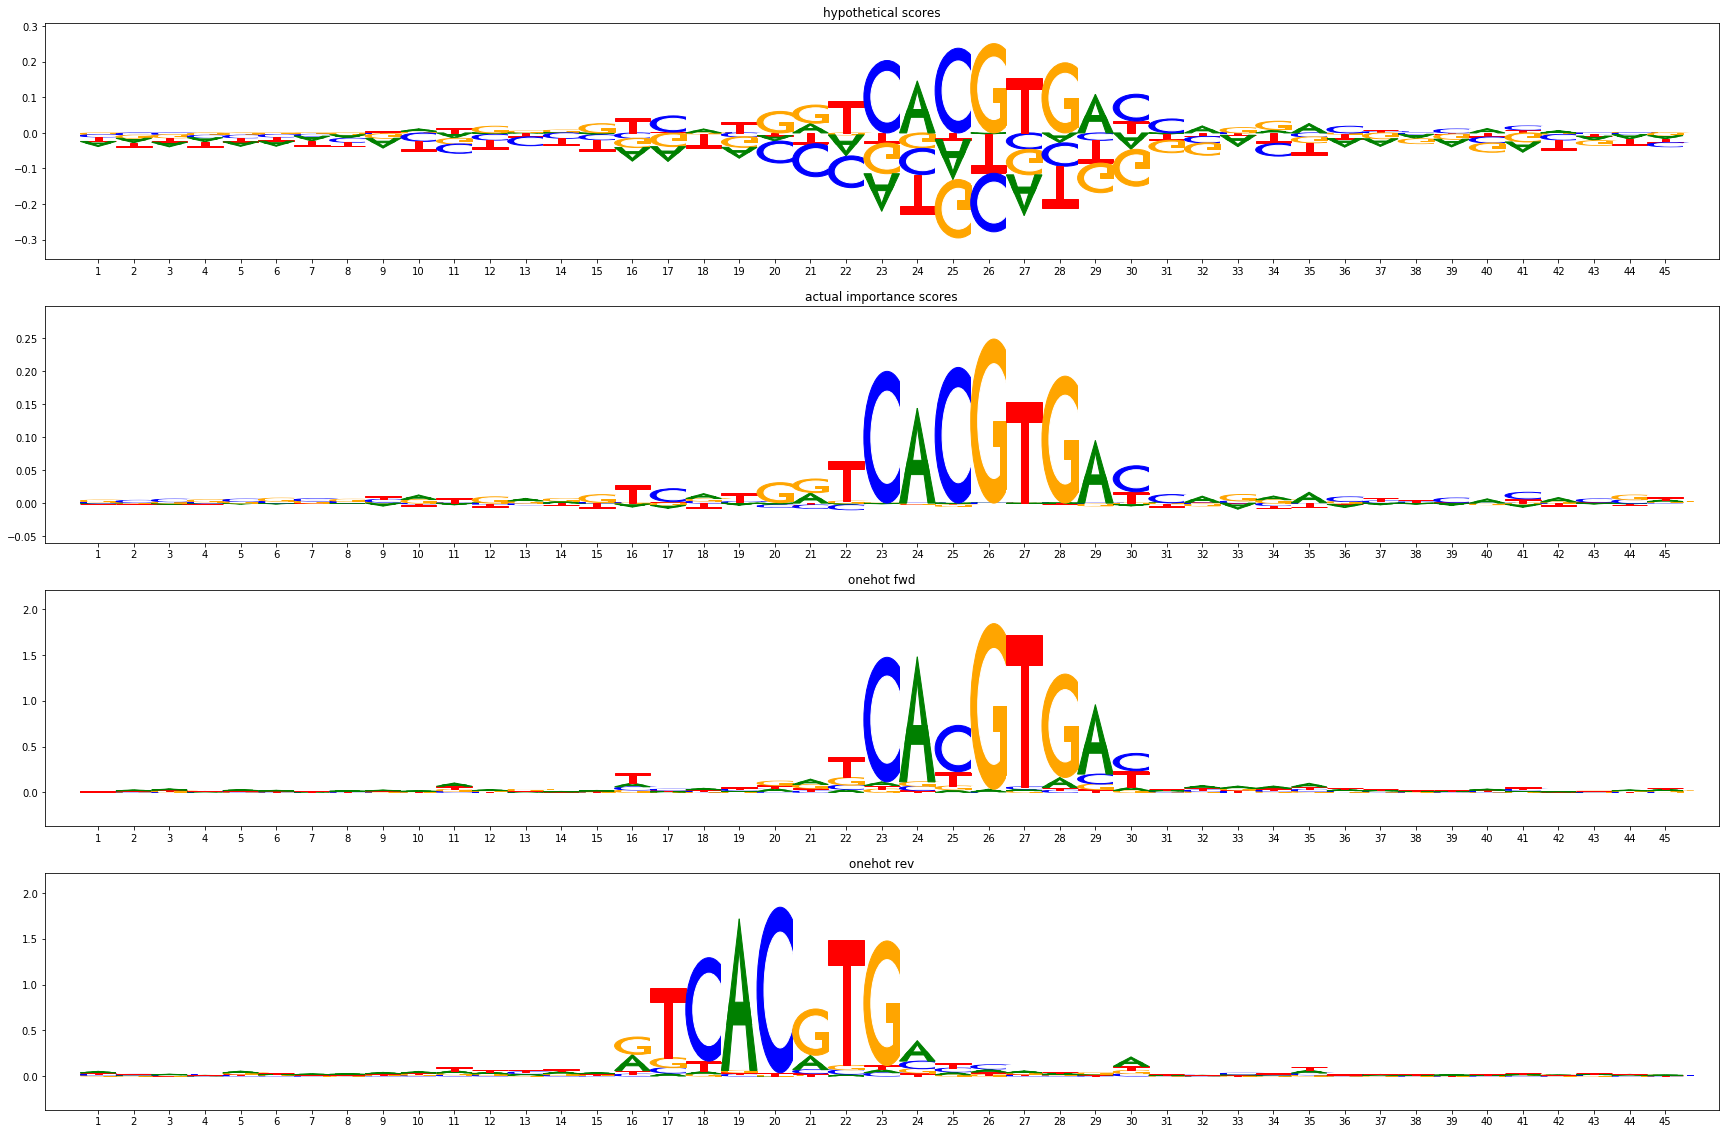


pattern_1: 496 seqlets



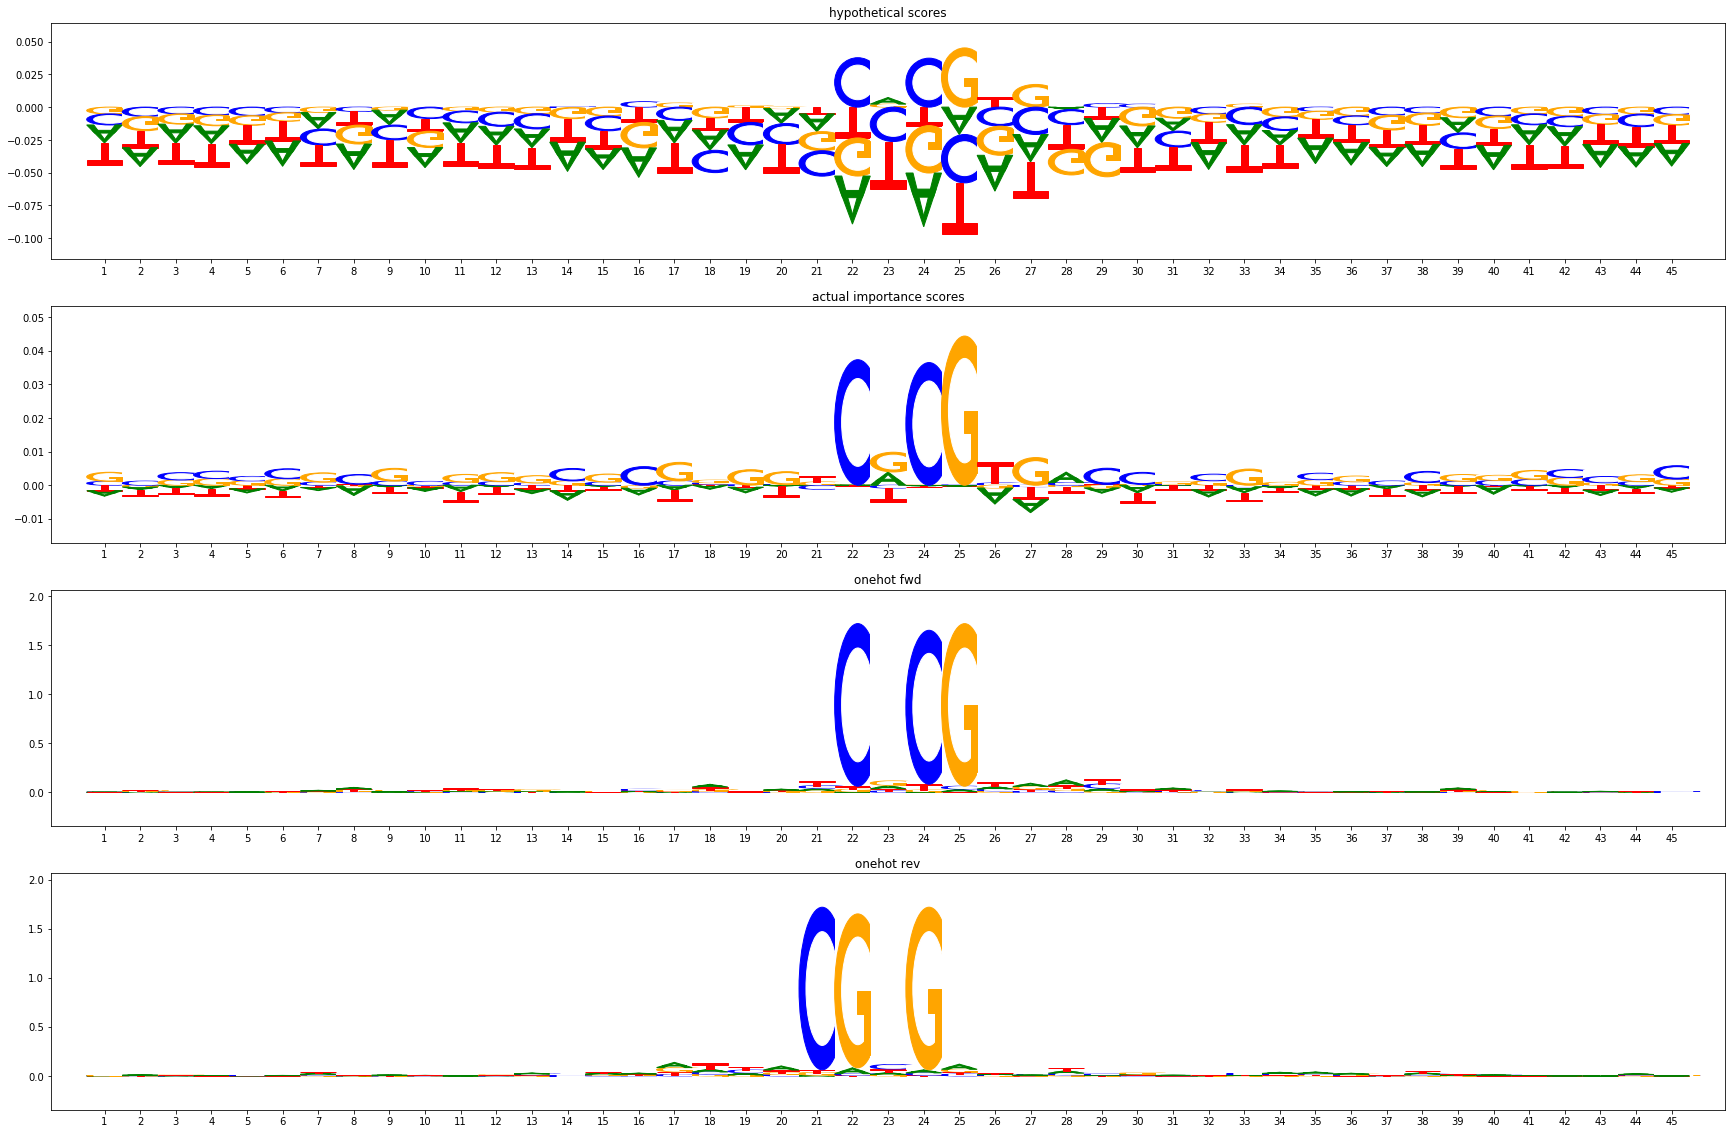


pattern_2: 156 seqlets



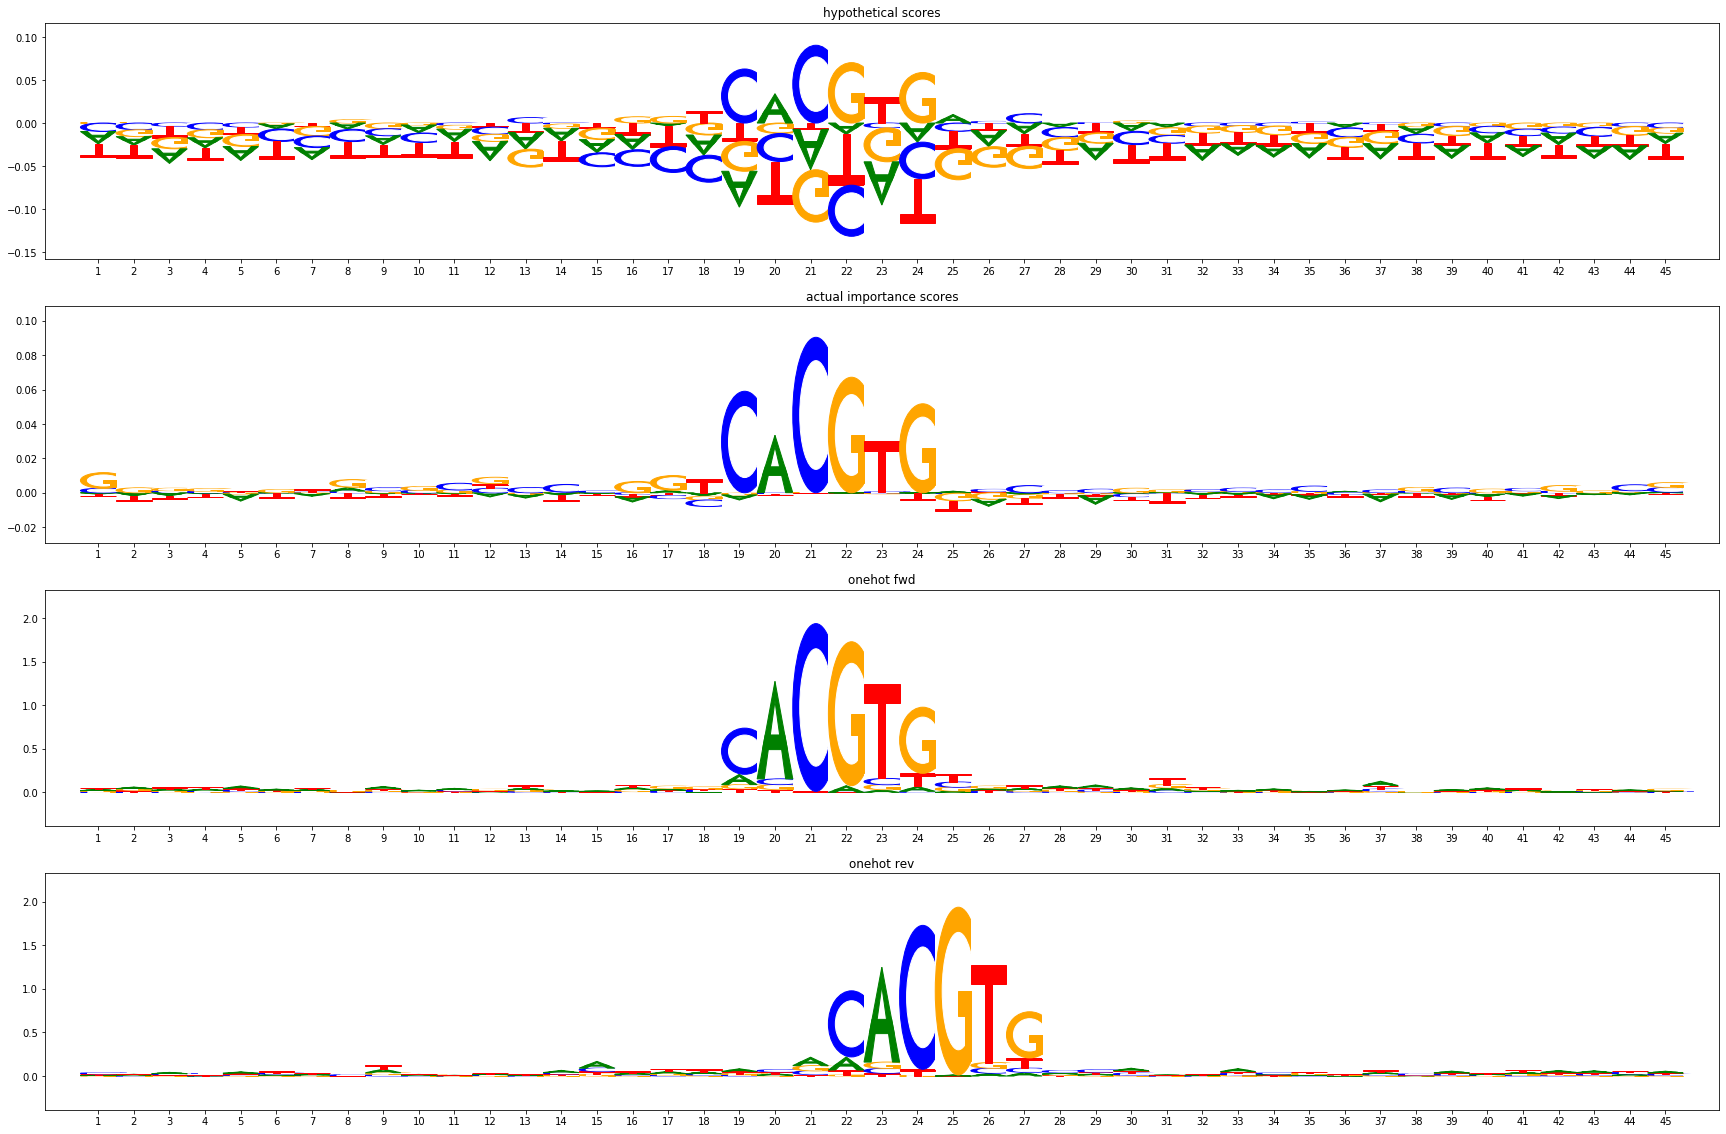


pattern_3: 130 seqlets



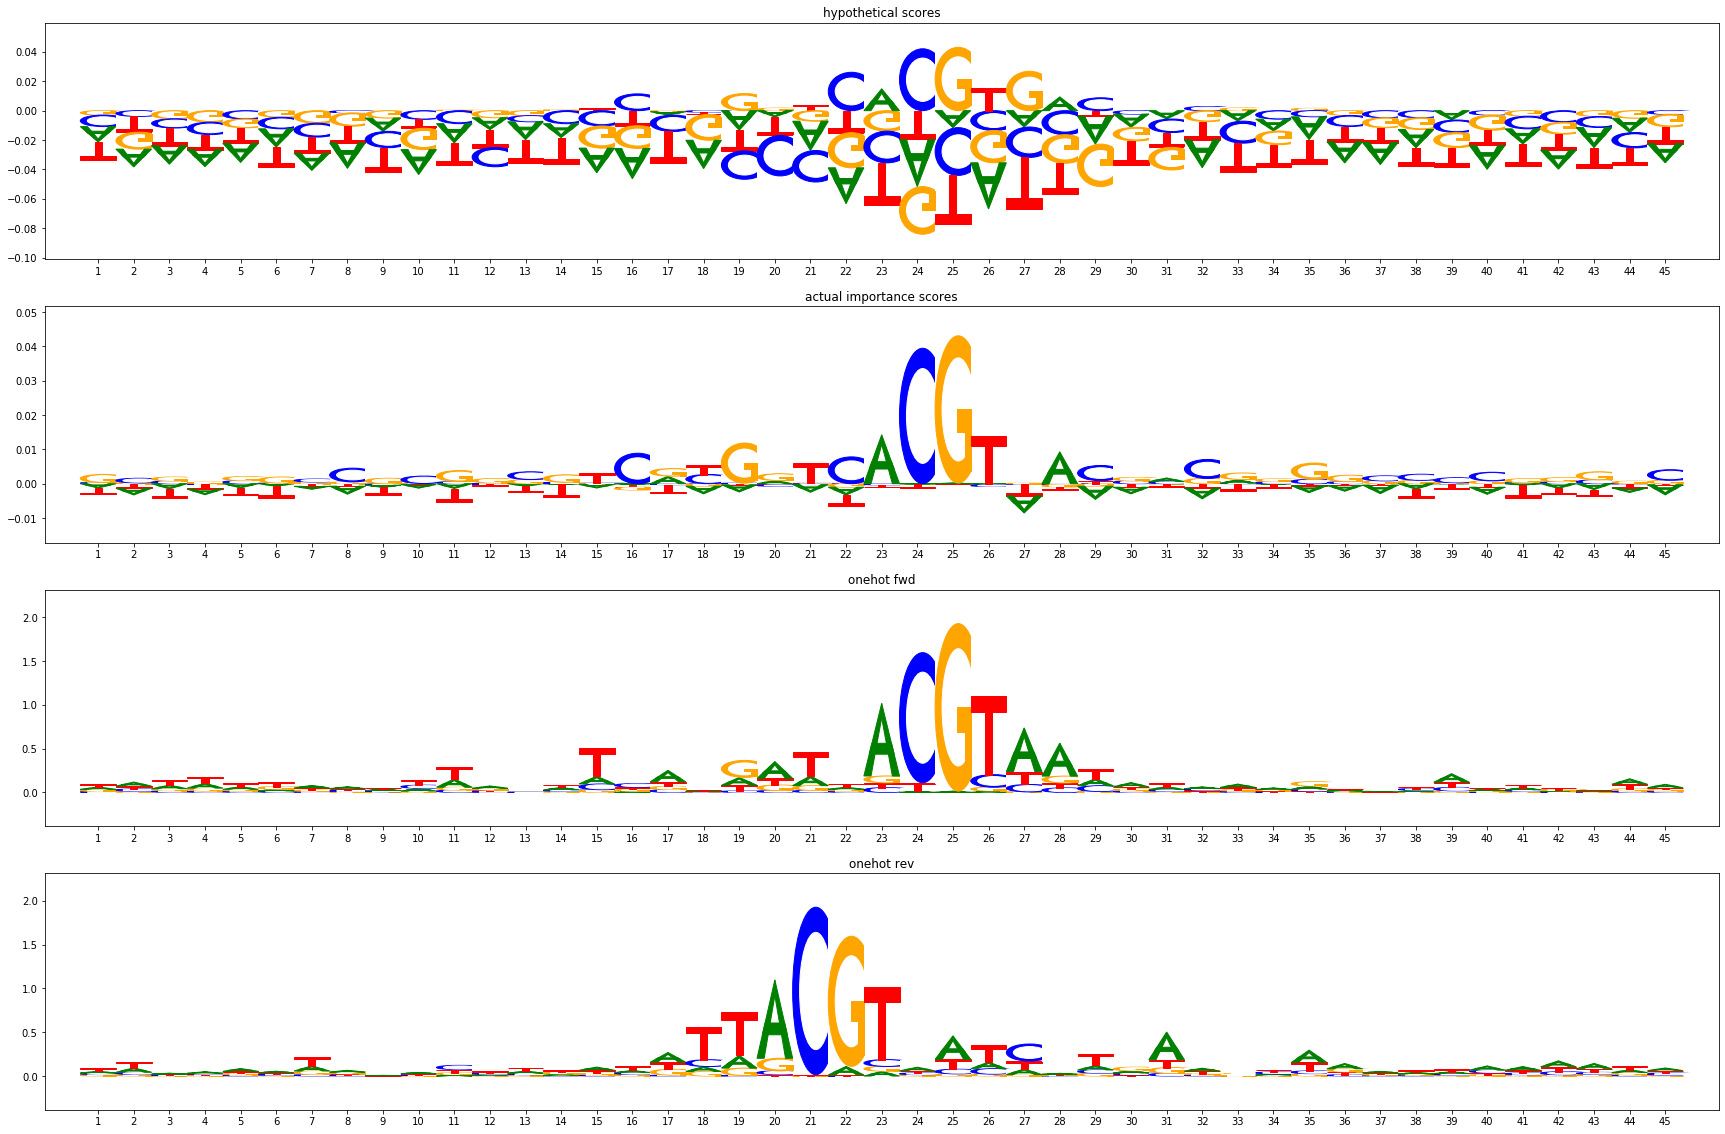


pattern_4: 100 seqlets



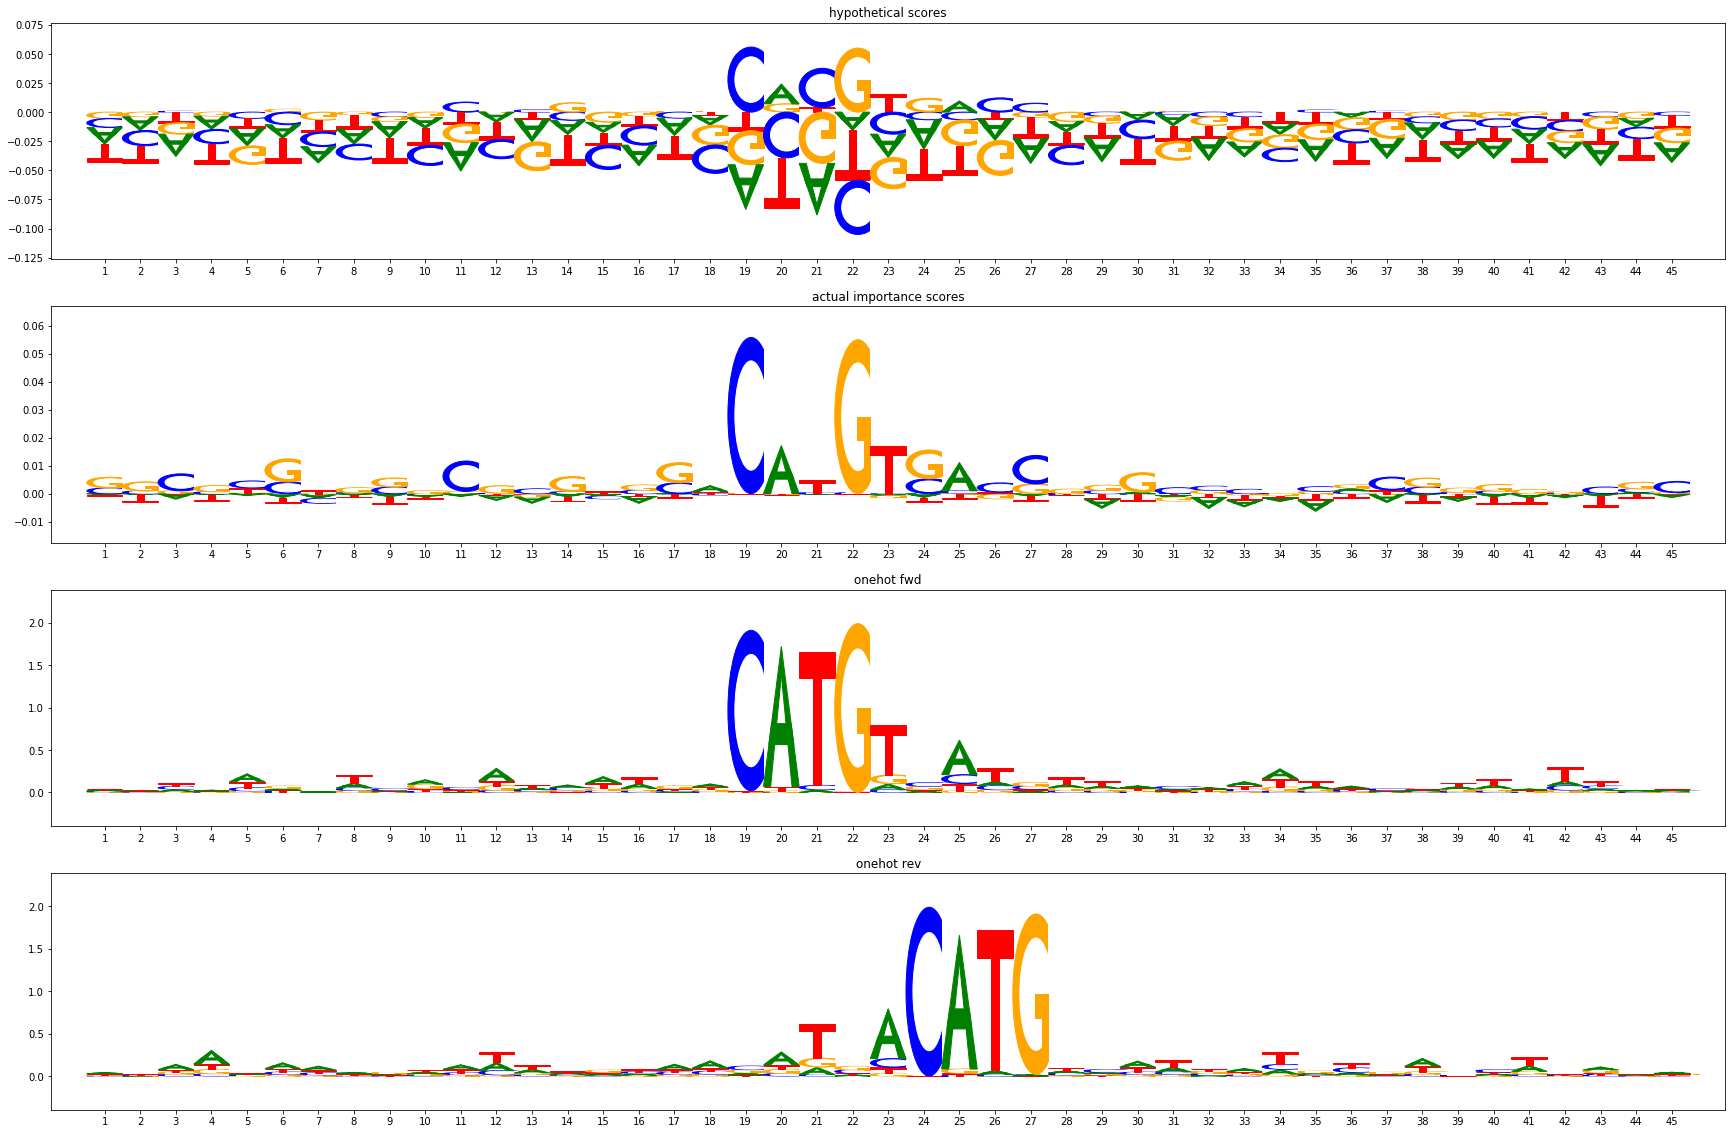


pattern_5: 106 seqlets



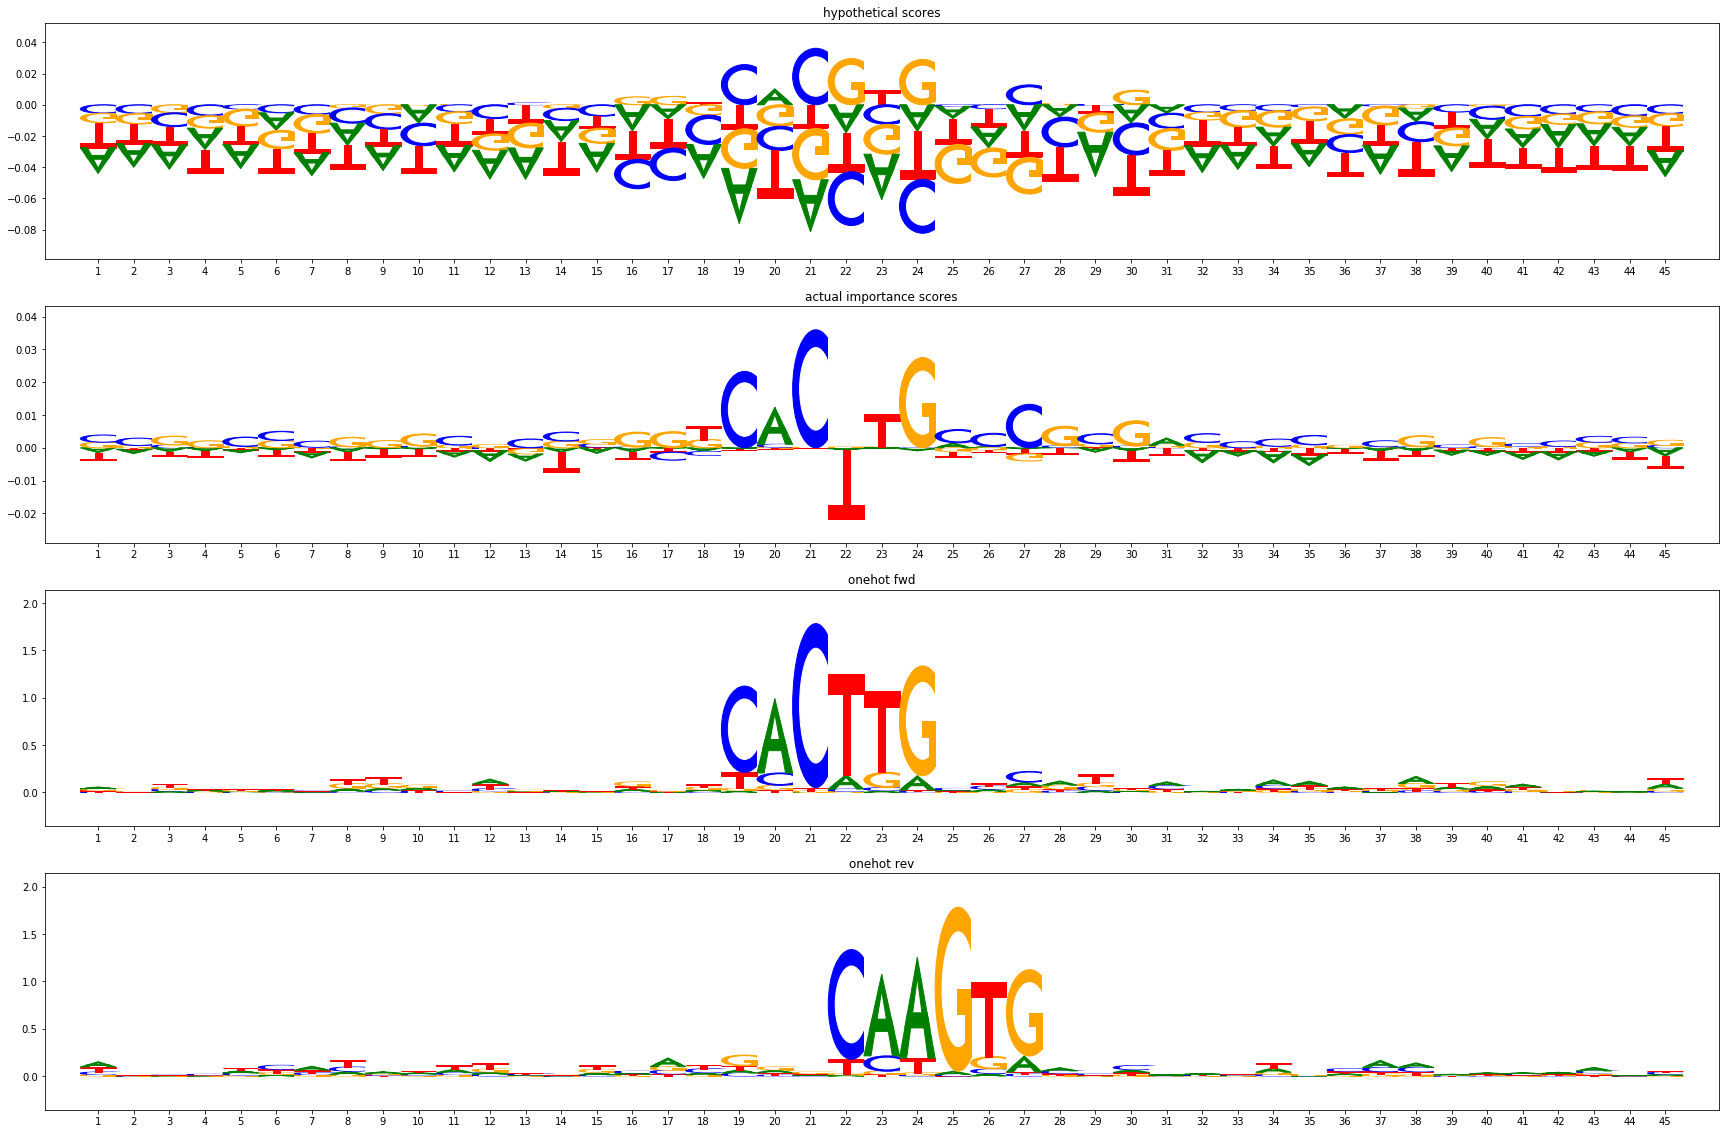

In [2]:
counts_hdf5_results = h5py.File("/users/amr1/pho4/data/modisco/cbf1_pbexo_big/task0_counts_results.hdf5","r")
activity_patterns = np.array(counts_hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(counts_hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
plt.figure()
sns.heatmap(activity_patterns, center=0)
plt.show()
metacluster_names = [
    x.decode("utf-8") for x in 
    list(counts_hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]
all_patterns = []
for metacluster_name in metacluster_names:
    print("\n"+metacluster_name+"\n")
    metacluster_grp = (counts_hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    for pattern_name in all_pattern_names:
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("\n"+pattern_name+": "+str(len(pattern["seqlets_and_alnmts"]["seqlets"]))+" seqlets\n")
        fig, ax = plt.subplots(4, 1, figsize=(30,20))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        plot_weights_given_ax(ax[0], pattern["task0_hypothetical_contribs"]["fwd"])
        ax[0].set_title("hypothetical scores")
        plot_weights_given_ax(ax[1], pattern["task0_contrib_scores"]["fwd"])
        ax[1].set_title("actual importance scores")
        plot_weights_given_ax(ax[2], viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background))
        ax[2].set_title("onehot fwd")
        plot_weights_given_ax(ax[3], viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        ax[3].set_title("onehot rev")
        plt.show()
counts_hdf5_results.close()

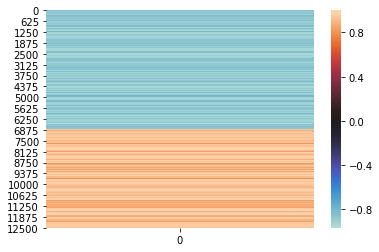


metacluster_0


pattern_0: 166 seqlets



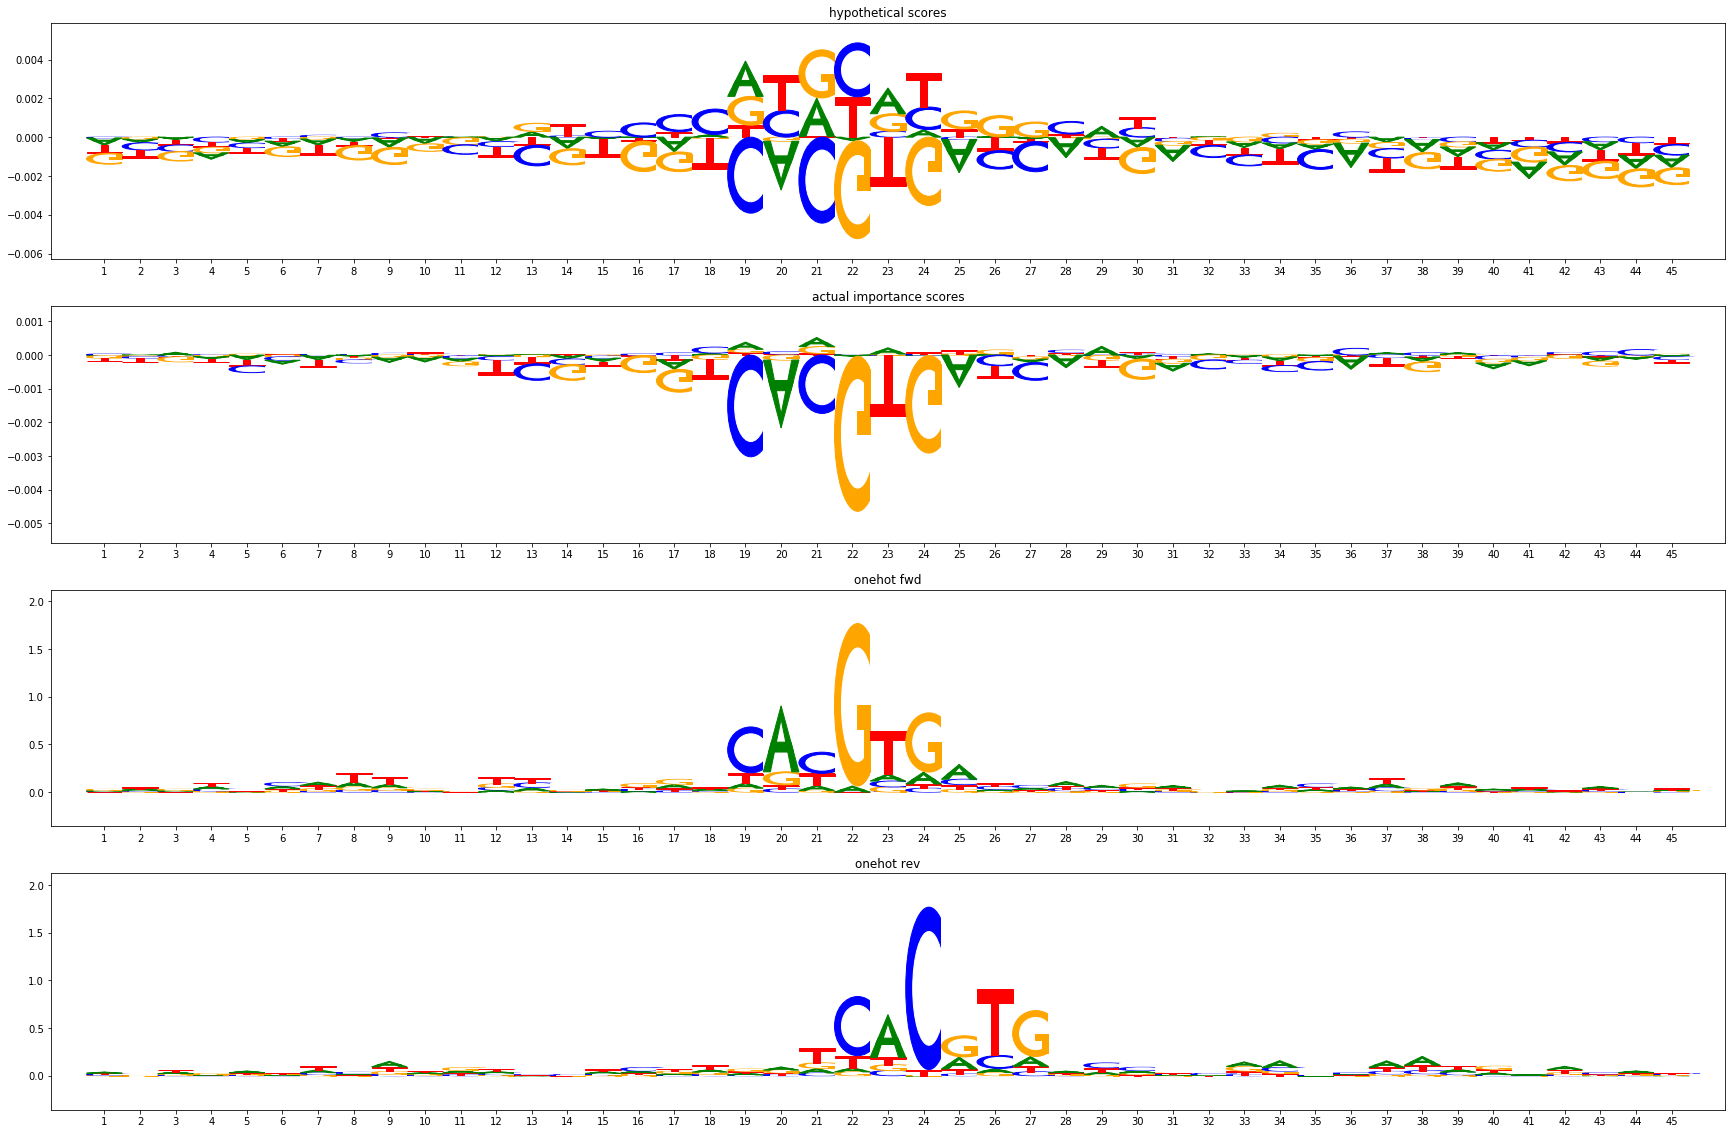


metacluster_1


pattern_0: 818 seqlets



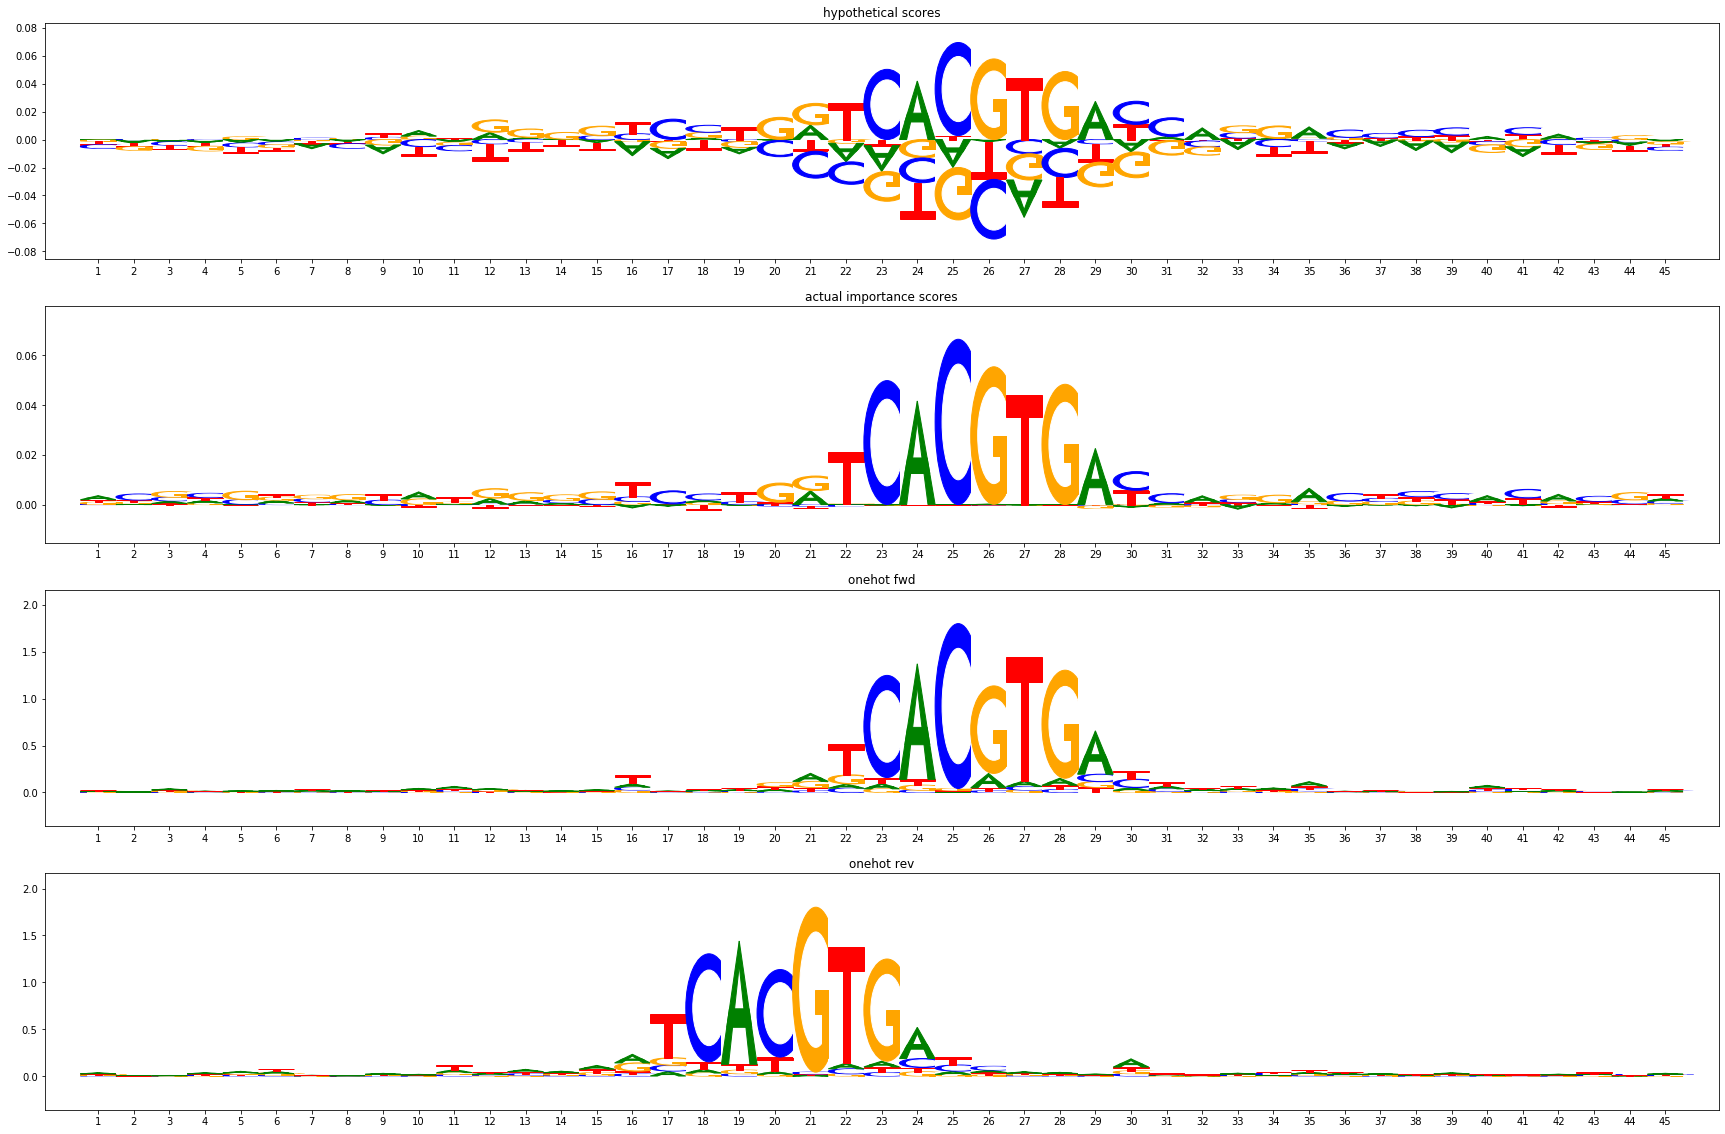


pattern_1: 146 seqlets



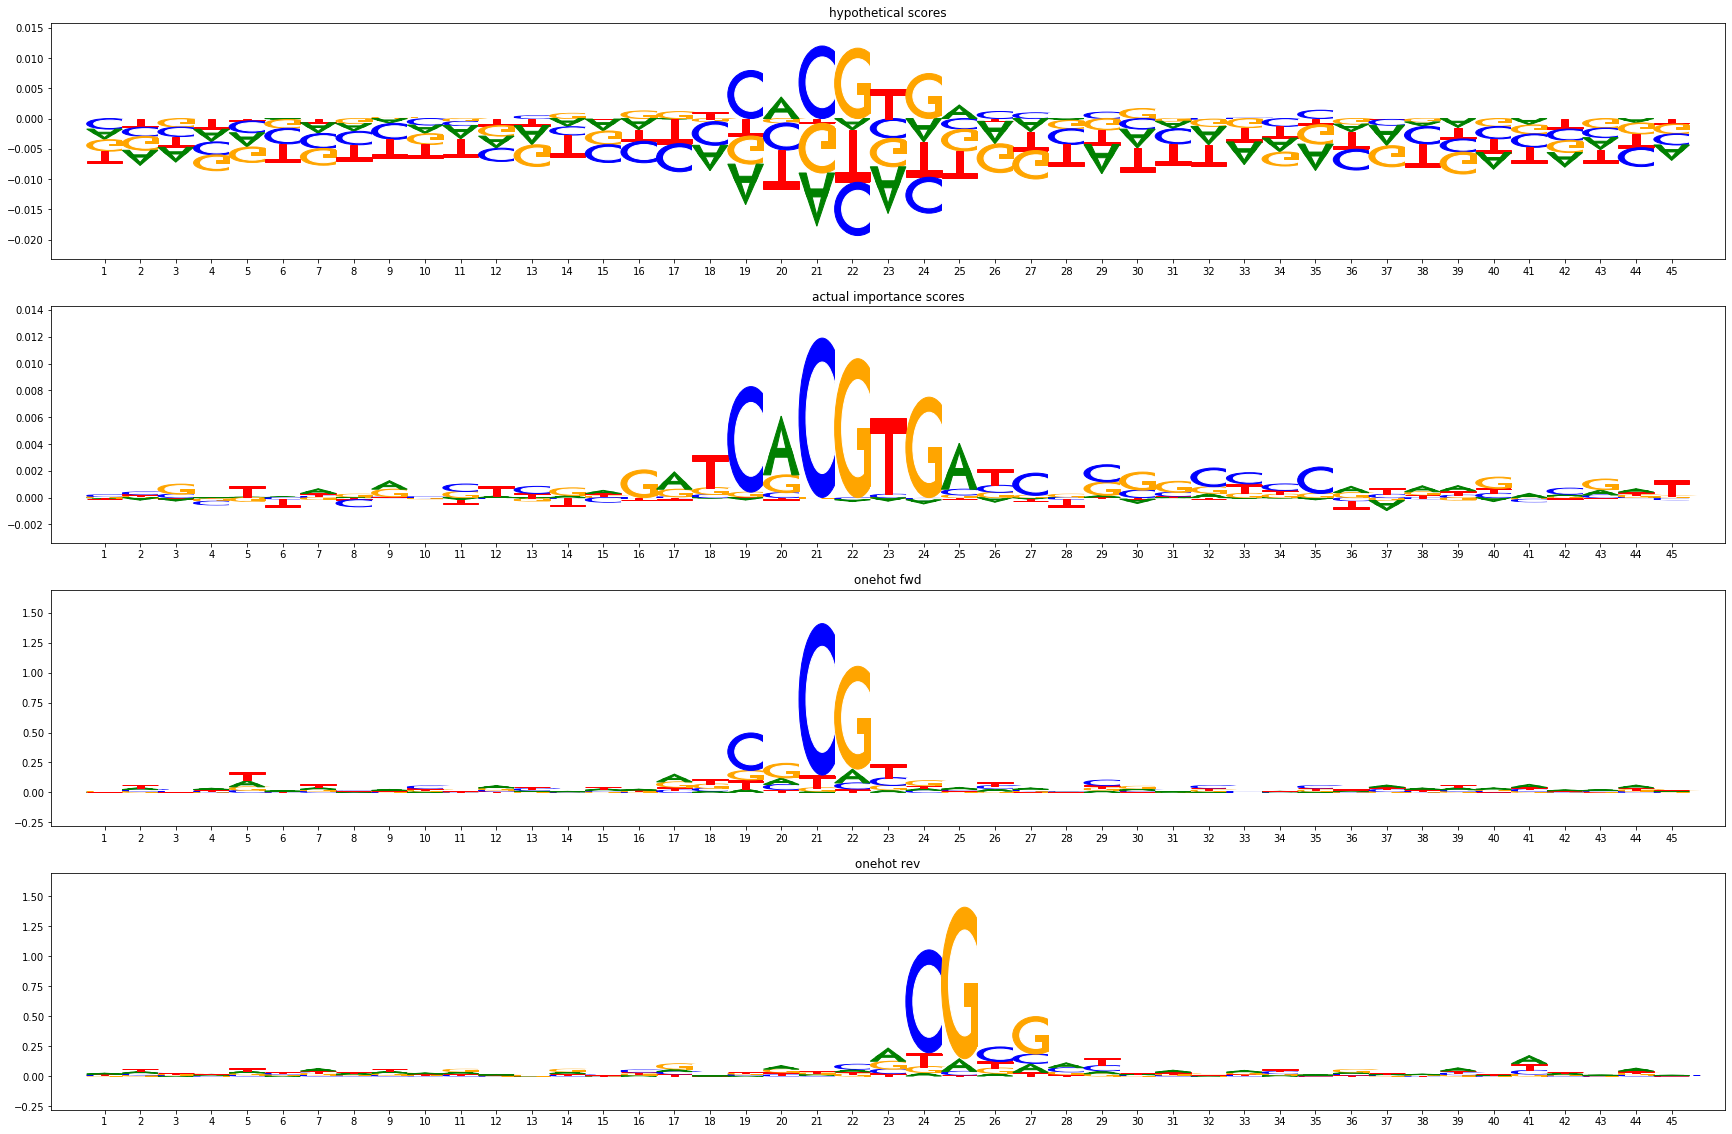


pattern_2: 84 seqlets



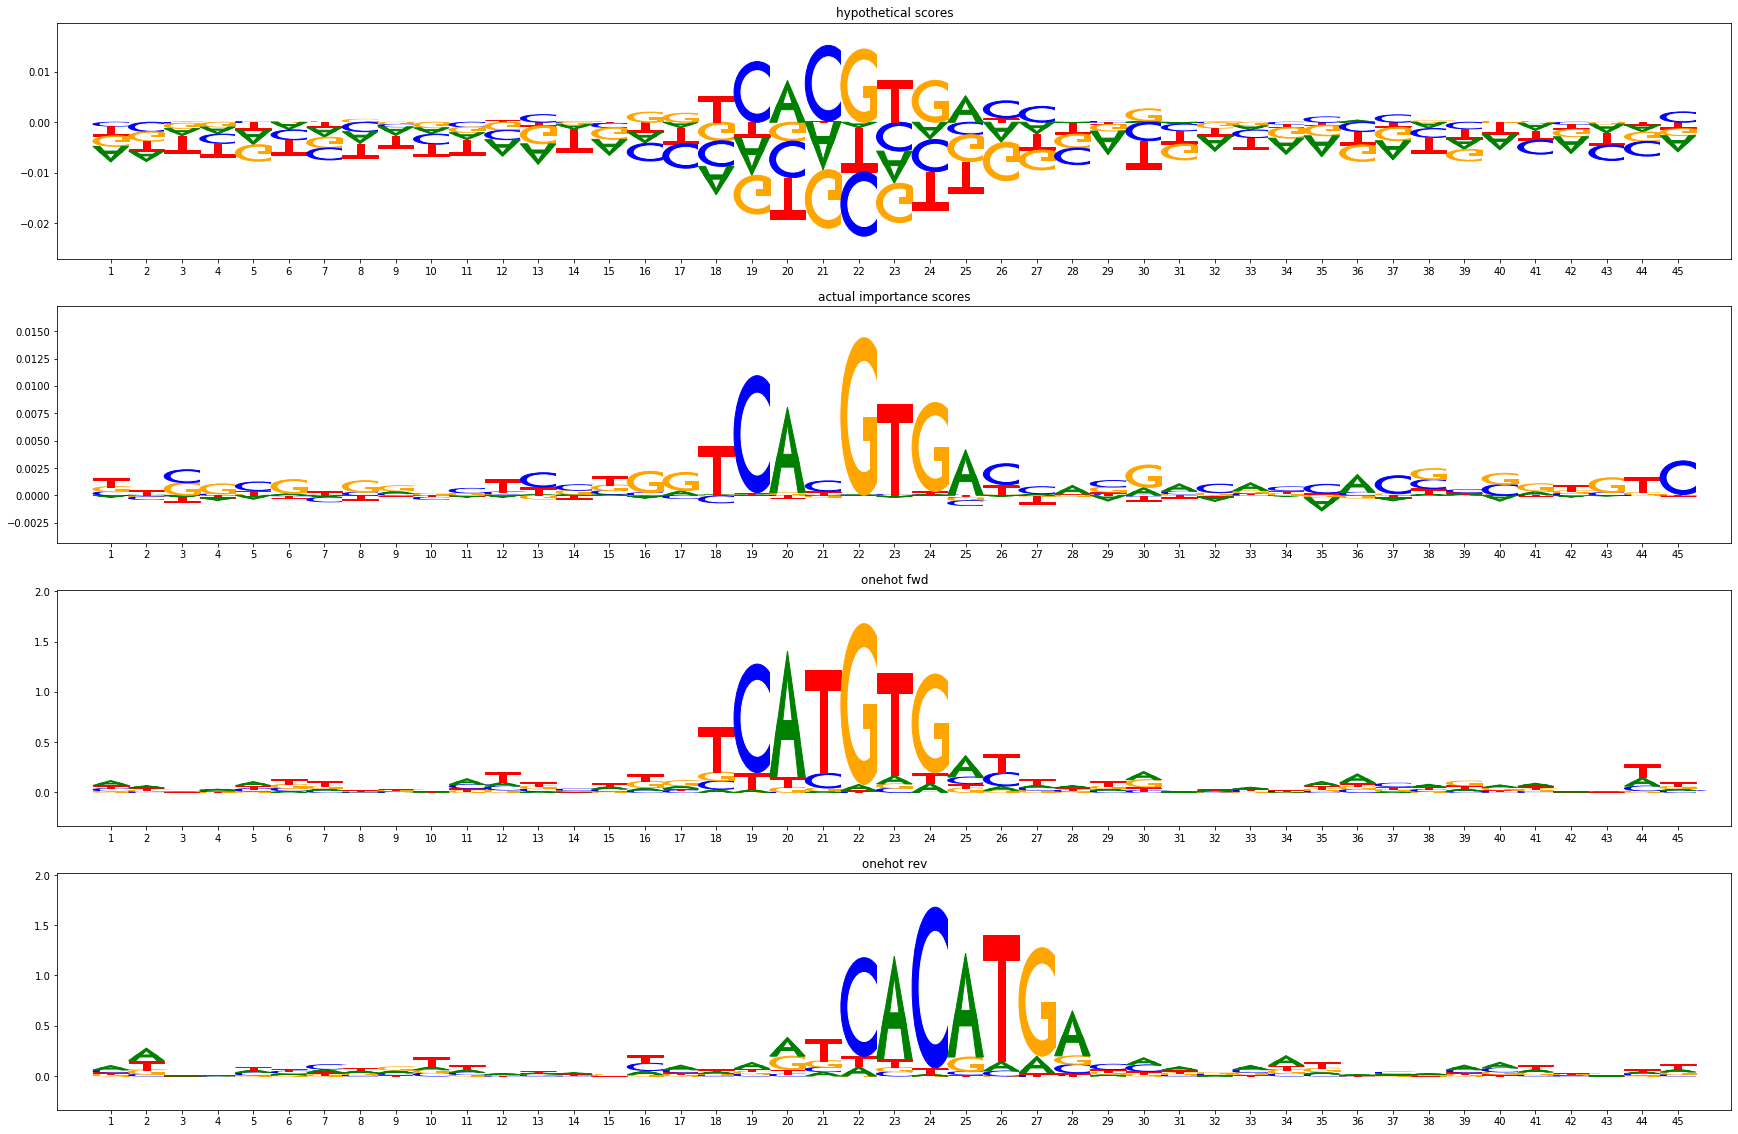

In [3]:
profile_hdf5_results = h5py.File("/users/amr1/pho4/data/modisco/cbf1_pbexo_big/task0_profile_results.hdf5","r")
activity_patterns = np.array(profile_hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(profile_hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
plt.figure()
sns.heatmap(activity_patterns, center=0)
plt.show()
metacluster_names = [
    x.decode("utf-8") for x in 
    list(profile_hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]
all_patterns = []
for metacluster_name in metacluster_names:
    print("\n"+metacluster_name+"\n")
    metacluster_grp = (profile_hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    for pattern_name in all_pattern_names:
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("\n"+pattern_name+": "+str(len(pattern["seqlets_and_alnmts"]["seqlets"]))+" seqlets\n")
        fig, ax = plt.subplots(4, 1, figsize=(30,20))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        plot_weights_given_ax(ax[0], pattern["task0_hypothetical_contribs"]["fwd"])
        ax[0].set_title("hypothetical scores")
        plot_weights_given_ax(ax[1], pattern["task0_contrib_scores"]["fwd"])
        ax[1].set_title("actual importance scores")
        plot_weights_given_ax(ax[2], viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background))
        ax[2].set_title("onehot fwd")
        plot_weights_given_ax(ax[3], viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        ax[3].set_title("onehot rev")
        plt.show()
profile_hdf5_results.close()

In [4]:
print("DONE")

DONE
